In [3]:
#mask
import json
import cv2
import os
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import keras
from keras.preprocessing import image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten 
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import to_categorical
import xml.etree.ElementTree as ET
from tensorflow.keras.callbacks import TensorBoard

from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [1]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [4]:
import keras
model_name = "mutiple_Conv1D_8_inputs_scaled_modified"
model = keras.models.load_model("D:/Project2022/models/"+model_name+".h5")

In [5]:
import time
model_name = "32_inputs_raw"
NAME = model_name+"-{}".format(int(time.time()))
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))

In [6]:
CATEGORIES = ["covid", "normal"]
DATADIR = "D:/Project2022/res/split_dataset/original/train"

In [40]:
def split_image_vertical(img_array):

    mid_v = int(img_array.shape[1]/4)
    LH_img = img_array[: , :int(img_array.shape[1]/2)]
    #plt.imshow(LH_img, cmap="gray")
    #plt.show()

     # mid vertical
    mid_ver = img_array[:, int((img_array.shape[1]/2)-mid_v):int((img_array.shape[1]/2)+mid_v)]
    #plt.imshow(mid_ver, cmap="gray")
    #plt.show()
    
    #Right half
    RH_img = img_array[: , int(img_array.shape[1]/2):]
    #plt.imshow(RH_img, cmap="gray")
    #plt.show()

    #print("----------------------------------------------------------")
    return [LH_img, mid_ver, RH_img]
    


In [41]:
def split_image_horizontal(img_array):
    mid_h = int(img_array.shape[0]/4)
    #top half
    TC_img = img_array[:int(img_array.shape[0]/2) , :]
    #plt.imshow(TC_img, cmap="gray")
    #plt.show()

    #mid horizontal
    mid_hor = img_array[int((img_array.shape[0]/2)-mid_h):int((img_array.shape[0]/2)+mid_h), :]
    #plt.imshow(mid_hor, cmap="gray")
    #plt.show()

    #bottom half
    BC_img =  img_array[int(img_array.shape[0]/2): , :]
    #plt.imshow(BC_img, cmap="gray")
    #plt.show()

    #print("############################################################")

    return [TC_img, mid_hor, BC_img]


In [42]:
def get_image(img_array):
    raw_data = []
    
    raw_data.append(img_array.sum(axis=0))
    raw_data.append(img_array.sum(axis=1))

    #print("Vetical splits")
    first_split_ver = split_image_vertical(img_array)


    for img in first_split_ver:
        raw_data.append(img.sum(axis=1))
        temp = split_image_vertical(img)
        for subset in temp:
            raw_data.append(subset.sum(axis=1))


    #print("Horizontal splits")
    first_split_hor = split_image_horizontal(img_array)
    for img in first_split_hor:
        raw_data.append(img.sum(axis=0))
        temp = split_image_horizontal(img)
        for subset in temp:
            raw_data.append(subset.sum(axis=0))
        
    return raw_data
    

       

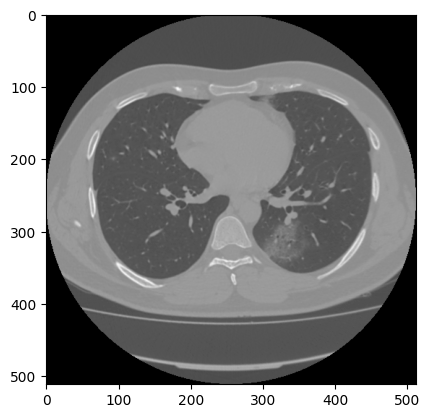

26


In [44]:
for categoty in CATEGORIES:
    path = os.path.join(DATADIR, categoty)  # path to Covid or Nprmal
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
        plt.imshow(img_array, cmap="gray")
        plt.show()

    
        temp = get_image(img_array)
        print(len(temp))

        break
    break

In [72]:
def pre_process_dataset(dataset_path):

    df_data = pd.DataFrame()
    dataset = []
    label = []

    for categoty in CATEGORIES:
        path = os.path.join(dataset_path, categoty)  
        
        class_num = CATEGORIES.index(categoty)
        
        print("Loading dataset: class",categoty)
        for img in tqdm(os.listdir(path)):

            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                img_array = cv2.resize(img_array, (512,512), interpolation= cv2.INTER_LINEAR)
                data = get_image(img_array)
                            
                dataset.append(data)
                label.append(class_num)
                
            except Exception as e:
                pass
    df_data["data_26"] = dataset
    df_data["label"] = label

    return df_data

In [73]:
dataset_df = pre_process_dataset(DATADIR)

Loading dataset: class covid


  0%|          | 0/5719 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/5514 [00:00<?, ?it/s]

In [77]:
dataset_df.head()

,data_26,label
0,"[[4576, 8086, 10445, 12245, 14048, 15508, 1667...",0
1,"[[12508, 12672, 12653, 12882, 13104, 13177, 13...",0
2,"[[2156, 2300, 2172, 2163, 2207, 2268, 2194, 23...",0
3,"[[2417, 2502, 2556, 2661, 2882, 3103, 3152, 30...",0
4,"[[3923, 3983, 4025, 4110, 4234, 4291, 4367, 49...",0


In [78]:
df_train, df_val = train_test_split(dataset_df, test_size=0.3, random_state=0)

In [79]:
df_train["label"].value_counts()

0    4041
1    3822
Name: label, dtype: int64

In [111]:
print("No of Training samples:",len(df_train))
print("No of Validation samples:",len(df_val))

No of Training samples: 7863
No of Validation samples: 3370


In [95]:
for sample in dataset_df["data_26"]:
    print(len(sample[0]))
    break

512


In [101]:
X1 = [img[0] for img in dataset_df["data_26"]]
X1 = np.array(X1)
X1 = preprocessing.normalize(X1)
X1 = np.expand_dims(X1, axis=-1)

In [119]:
from sklearn import preprocessing
def type_conversion(feature):

    X = [img[feature] for img in df_val["data_26"]]
    X = np.array(X)
    X = preprocessing.normalize(X)
    X = np.expand_dims(X, axis=-1)

    return X


In [120]:
from sklearn import preprocessing

def process_data(dataset_df):
    
    
    # global
    X1 = type_conversion(0)
    X2 = type_conversion(1)
    X3 = type_conversion(2)
    X4 = type_conversion(3)
    X5 = type_conversion(4)
    X6 = type_conversion(5)
    X7 = type_conversion(6)
    X8 = type_conversion(7)
    X9 = type_conversion(8)
    X10 = type_conversion(9)
    X11 = type_conversion(10)
    X12 = type_conversion(11)
    X13 = type_conversion(12)
    X14 = type_conversion(13)
    X15 = type_conversion(14)
    X16 = type_conversion(15)
    X17 = type_conversion(16)
    X18 = type_conversion(17)
    X19 = type_conversion(18)
    X20 = type_conversion(19)
    X21 = type_conversion(20)
    X22 = type_conversion(21)
    X23 = type_conversion(22)
    X24 = type_conversion(23)
    X25 = type_conversion(24)
    X26 = type_conversion(25)
    
    y = np.array(dataset_df["label"].values)
    y = np.expand_dims(y, axis=-1)


    print("X1 shape", X1.shape)
    print("X2 shape", X2.shape)
    print("X3 shape", X3.shape)
    print("X4 shape", X4.shape)
    print("X5 shape", X5.shape)
    print("X6 shape", X6.shape)
    print("X7 shape", X7.shape)
    print("X8 shape", X8.shape)
    print("X9 shape", X9.shape)
    print("X10 shape", X10.shape)
    print("X11 shape", X11.shape)
    print("X12 shape", X12.shape)
    print("X13 shape", X13.shape)
    print("X14 shape", X14.shape)
    print("X15 shape", X15.shape)
    print("X16 shape", X16.shape)
    print("X17 shape", X17.shape)
    print("X18 shape", X18.shape)
    print("X19 shape", X19.shape)
    print("X20 shape", X20.shape)
    print("X21 shape", X21.shape)
    print("X22 shape", X22.shape)
    print("X23 shape", X23.shape)
    print("X24 shape", X24.shape)
    print("X25 shape", X25.shape)
    print("X26 shape", X26.shape)
    

    print("y shape", y.shape)
            #X 0 t0 25
            #y 26
    return [X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14, X15, X16, X17, X18, X19, X20, X21, X22, X23, X24, X25, X26, y]

In [118]:
print("Training samples:")
train_data = process_data(df_train)


Training samples:
X1 shape (7863, 512, 1)
X2 shape (7863, 512, 1)
X3 shape (7863, 512, 1)
X4 shape (7863, 512, 1)
X5 shape (7863, 512, 1)
X6 shape (7863, 512, 1)
X7 shape (7863, 512, 1)
X8 shape (7863, 512, 1)
X9 shape (7863, 512, 1)
X10 shape (7863, 512, 1)
X11 shape (7863, 512, 1)
X12 shape (7863, 512, 1)
X13 shape (7863, 512, 1)
X14 shape (7863, 512, 1)
X15 shape (7863, 512, 1)
X16 shape (7863, 512, 1)
X17 shape (7863, 512, 1)
X18 shape (7863, 512, 1)
X19 shape (7863, 512, 1)
X20 shape (7863, 512, 1)
X21 shape (7863, 512, 1)
X22 shape (7863, 512, 1)
X23 shape (7863, 512, 1)
X24 shape (7863, 512, 1)
X25 shape (7863, 512, 1)
X26 shape (7863, 512, 1)
y shape (7863, 1)


In [121]:
print("Validation samples:")
val_data = process_data(df_val)


Validation samples:
X1 shape (3370, 512, 1)
X2 shape (3370, 512, 1)
X3 shape (3370, 512, 1)
X4 shape (3370, 512, 1)
X5 shape (3370, 512, 1)
X6 shape (3370, 512, 1)
X7 shape (3370, 512, 1)
X8 shape (3370, 512, 1)
X9 shape (3370, 512, 1)
X10 shape (3370, 512, 1)
X11 shape (3370, 512, 1)
X12 shape (3370, 512, 1)
X13 shape (3370, 512, 1)
X14 shape (3370, 512, 1)
X15 shape (3370, 512, 1)
X16 shape (3370, 512, 1)
X17 shape (3370, 512, 1)
X18 shape (3370, 512, 1)
X19 shape (3370, 512, 1)
X20 shape (3370, 512, 1)
X21 shape (3370, 512, 1)
X22 shape (3370, 512, 1)
X23 shape (3370, 512, 1)
X24 shape (3370, 512, 1)
X25 shape (3370, 512, 1)
X26 shape (3370, 512, 1)
y shape (3370, 1)


In [122]:
def conv1D_layer(input, nodes):
    #Input(shape=(367,1))
    #input_layer = Input(shape=inputSize)
    #kernel size- 5
    # nodes - 16
    conv1 = Conv1D(nodes, kernel_size=5, activation='relu')(input)
    drop1 = Dropout(0.25)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat = Flatten()(pool1)
    return flat

## Modified

In [123]:
# first input model
X1 = Input(shape=(512,1))
flat1 = conv1D_layer(X1, 16)

# second input model
X2 = Input(shape=(512,1))
flat2 = conv1D_layer(X2, 16)

#####################################################################

X3 = Input(shape=(512,1))
flat3 = conv1D_layer(X3, 16)

X4 = Input(shape=(512,1))
flat4 = conv1D_layer(X4, 16)

X5 = Input(shape=(512,1))
flat5 = conv1D_layer(X5, 16)

X6 = Input(shape=(512,1))
flat6 = conv1D_layer(X6, 16)

X7 = Input(shape=(512,1))
flat7 = conv1D_layer(X7, 16)

X8 = Input(shape=(512,1))
flat8 = conv1D_layer(X8, 16)

X9 = Input(shape=(512,1))
flat9 = conv1D_layer(X9, 16)

X10 = Input(shape=(512,1))
flat10 = conv1D_layer(X10, 16)

X11 = Input(shape=(512,1))
flat11 = conv1D_layer(X11, 16)

X12 = Input(shape=(512,1))
flat12 = conv1D_layer(X12, 16)







LH = Input(shape=(512,1))
flat3 = conv1D_layer(LH, 16)

row_mid = Input(shape=(252,1))
flat4 = conv1D_layer(row_mid, 16)

RH = Input(shape=(512,1))
flat5 = conv1D_layer(RH, 16)


TC = Input(shape=(512,1))
flat6 = conv1D_layer(LH, 16)

col_mid = Input(shape=(512,1))
flat7 = conv1D_layer(col_mid, 16)

BC = Input(shape=(512,1))
flat8 = conv1D_layer(BC, 16)


merge_all = concatenate([flat_row, flat_col, flat3, flat4, flat5, flat6, flat7,flat8])
#32
hidden_all_1 = Dense(32, activation='relu')(merge_all)
#16
hidden_all_2 = Dense(16, activation='relu')(hidden_all_1)

output = Dense(1, activation='sigmoid')(hidden_all_2)
model = Model(inputs=[row, col, LH, row_mid, RH, TC, col_mid, BC], outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# summarize layers
print(model.summary())

NameError: name 'flat_row' is not defined

In [20]:

BATCH_SIZE = 128
EPOCHS = 500
history = model.fit(
    [X1_train, X2_train, X3_train, X_row_mid, X4_train, X5_train, X_col_mid, X6_train],
    Y_train,
    BATCH_SIZE,
    EPOCHS,
    validation_data=([X1_val, X2_val, X3_val, X_row_mid_val, X4_val, X5_val, X_mid_col_val, X6_val], Y_val),
    callbacks=[tensorboard])

model.save("D:/Project2022/models/"+model_name+".h5")

Epoch 1/500
71/71 [==============================] - 19s 83ms/step - loss: 0.5968 - accuracy: 0.7210 - val_loss: 0.5300 - val_accuracy: 0.7980
Epoch 2/500
71/71 [==============================] - 5s 67ms/step - loss: 0.4757 - accuracy: 0.7901 - val_loss: 0.4622 - val_accuracy: 0.8051
Epoch 3/500
71/71 [==============================] - 5s 66ms/step - loss: 0.4381 - accuracy: 0.8041 - val_loss: 0.4318 - val_accuracy: 0.8166
Epoch 4/500
71/71 [==============================] - 5s 67ms/step - loss: 0.4250 - accuracy: 0.8106 - val_loss: 0.4322 - val_accuracy: 0.8184
Epoch 5/500
71/71 [==============================] - 5s 67ms/step - loss: 0.4052 - accuracy: 0.8198 - val_loss: 0.4035 - val_accuracy: 0.8322
Epoch 6/500
71/71 [==============================] - 5s 66ms/step - loss: 0.3890 - accuracy: 0.8314 - val_loss: 0.3932 - val_accuracy: 0.8389
Epoch 7/500
71/71 [==============================] - 5s 66ms/step - loss: 0.3862 - accuracy: 0.8283 - val_loss: 0.3940 - val_accuracy: 0.8478
Epoch

KeyboardInterrupt: 

In [4]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [3]:
import keras
model_name = "mutiple_Conv1D_8_inputs_scaled_modified"
model = keras.models.load_model("D:/Project2022/models/"+model_name+".h5")

In [16]:
model_name

'mutiple_Conv1D_8_inputs_scaled_modified'

# Evaluate the Model using test data

In [23]:
Test_DATADIR = "D:/Project2022/res/split_dataset/original/test"
dataset_df = pre_process_dataset(Test_DATADIR)


Loading dataset: class covid


  0%|          | 0/1430 [00:00<?, ?it/s]

Loading dataset: class normal


  0%|          | 0/1379 [00:00<?, ?it/s]

In [24]:
print("No of test sample:", len(dataset_df))

No of test sample: 2809


In [25]:
X1_test, X2_test, X3_test, X_row_mid_test, X4_test, X5_test, X_col_mid_test, X6_test, Y_test = process_data(dataset_df)

X1 shape (2809, 367, 1)
X2 shape (2809, 252, 1)
X3 shape (2809, 252, 1)
Mid rows shape (2809, 252, 1)
X4 shape (2809, 252, 1)
X5 shape (2809, 367, 1)
Mid Cols shape (2809, 367, 1)
X6 shape (2809, 367, 1)
y shape (2809, 1)


In [26]:
# test loss, test accuracy
accuracy = model.evaluate([X1_test, X2_test, X3_test, X_row_mid_test, X4_test, X5_test, X_col_mid_test, X6_test], Y_test, batch_size=100, verbose=0)

In [27]:
print("Test acuuracy", accuracy[1])
print("Test loss", accuracy[0])

Test acuuracy 0.9619081616401672
Test loss 0.20270198583602905


In [28]:
#y_pred = model.predict_classes(X_test)
y_pred = (model.predict([X1_test, X2_test, X3_test, X_row_mid_test, X4_test, X5_test, X_col_mid_test, X6_test]) > 0.5).astype("int32")

88/88 [==============================] - 2s 10ms/step


In [29]:
print(classification_report(Y_test, y_pred, target_names=["covid", "Normal"]))

              precision    recall  f1-score   support

       covid       0.97      0.96      0.96      1430
      Normal       0.96      0.97      0.96      1379

    accuracy                           0.96      2809
   macro avg       0.96      0.96      0.96      2809
weighted avg       0.96      0.96      0.96      2809



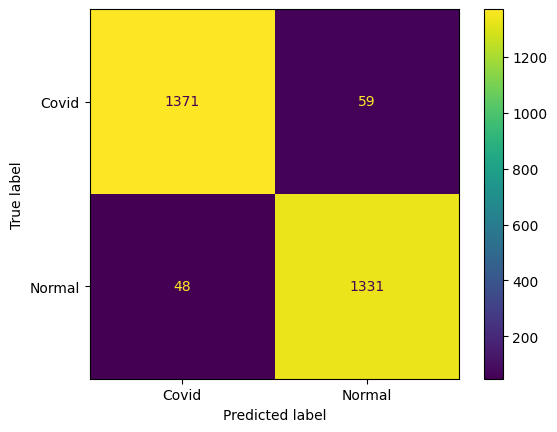

In [30]:
cm = confusion_matrix(Y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Covid","Normal"])
disp.plot()
plt.show()
